In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from stutter.data.fluencybank import FluencyBankSlow, FluencyBank
from stutter.config import cfg
from torch.utils.data import DataLoader
from tqdm import tqdm


#### Analyze Fluency Bank

In [13]:
cfg.data.name = 'fluencybank'
cfg.data.root = '../../datasets/fluencybank/clips'
cfg.data.label_path = '../../outputs/fluencybank/fluencybank_labels_new_split.csv'
cfg.data.ckpt = '../../outputs/debug'
cfg.data.n_mels = 40

train_dataset = FluencyBank(**cfg.data, split='train')
val_dataset = FluencyBank(**cfg.data, split='val')
test_dataset = FluencyBank(**cfg.data, split='test')
print(len(train_dataset), len(val_dataset), len(test_dataset))

************ Loading Dataset ************


100%|██████████| 3211/3211 [04:39<00:00, 11.50it/s]


Failed to load 0 files
************ Loading Dataset ************


100%|██████████| 424/424 [00:37<00:00, 11.35it/s]


Failed to load 0 files
************ Loading Dataset ************


100%|██████████| 312/312 [00:27<00:00, 11.50it/s]


Failed to load 0 files
3211 424 312


In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

label = train_dataset.label
weight = [np.unique((label>=2).float()[:,i], return_counts=True)[1][0]/len(train_dataset) for i in range(6)]

### Train model

In [6]:
import torch.nn as nn
import torch
from sklearn.metrics import f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


model = LSTM(input_size=40, hidden_size=64, num_layers=1, num_classes=6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss(weight=torch.tensor([1, 1, 1, 1, 0.9, 0.7]).to(device))

cuda


In [7]:
# train function
def train_epoch(epoch, model, data_loader, criterion, optimizer):
    model.train()
    model.to(device)
    running_loss = 0.0
    for i, batch in tqdm(enumerate(data_loader)):
        data, label = batch['mel_spec'].to(device), batch['label'].to(device)
        label = (label>=2).float()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(data_loader)

def validate(model, data_loader, criterion):
    model.eval()
    model.to(device)
    running_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            data, label = batch['mel_spec'].to(device), batch['label'].to(device)
            outputs = model(data)
            loss = criterion(outputs, label)
            running_loss += loss.item()
    return running_loss / len(data_loader)

def f1_macro (y_true, y_pred):
    f1_per_class = []
    for i in range(6):
        y_true[:,i] = (y_true[:,i]>=2).astype(int)
        y_pred[:,i] = (y_pred[:,i]>=0).astype(int)
        f1_per_class.append(f1_score(y_true[:,i], y_pred[:,i], average='binary'))
    return f1_per_class

def weighted_accuracy(y_true, y_pred):
    acc_per_class = []
    for i in range(6):
        y_true[:,i] = (y_true[:,i]>=2).astype(int)
        y_pred[:,i] = (y_pred[:,i]>=0).astype(int)
        acc_per_class.append(np.sum(y_true[:,i]==y_pred[:,i])/len(y_true))
    return acc_per_class

def test(model, data_loader, criterion):
    model.eval()
    model.to(device)

    test_data = next(iter(data_loader))
    with torch.no_grad():
        data, label = test_data['mel_spec'].to(device), test_data['label'].to(device)
        outputs = model(data)
        f1 = f1_macro(label.cpu().numpy(), torch.sigmoid(outputs).cpu().numpy())
        loss = criterion(outputs, label)/len(data_loader)
        acc = weighted_accuracy(label.cpu().numpy(), torch.sigmoid(outputs).cpu().numpy())
    return loss, f1, acc

In [8]:
num_epochs = 100
train_loss = []
val_loss = []
for epoch in tqdm(range(num_epochs)):
    train_loss.append(train_epoch(epoch, model, train_loader, criterion, optimizer))
    val_loss.append(validate(model, val_loader, criterion))
    # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}')

test_loss, test_f1, test_acc = test(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test F1: {test_f1}, Test Acc: {test_acc}')

26it [00:01, 25.55it/s][00:00<?, ?it/s]
  1%|          | 1/100 [00:01<01:59,  1.20s/it]

Epoch 1/100, Train Loss: 0.5512, Val Loss: 0.8132


26it [00:00, 130.35it/s]
  2%|▏         | 2/100 [00:01<01:01,  1.59it/s]

Epoch 2/100, Train Loss: 0.3991, Val Loss: 0.9903


26it [00:00, 131.37it/s]
  3%|▎         | 3/100 [00:01<00:42,  2.26it/s]

Epoch 3/100, Train Loss: 0.3972, Val Loss: 0.9570


26it [00:00, 129.38it/s]
  4%|▍         | 4/100 [00:01<00:34,  2.80it/s]

Epoch 4/100, Train Loss: 0.3926, Val Loss: 0.9556


26it [00:00, 137.83it/s]
  5%|▌         | 5/100 [00:02<00:29,  3.27it/s]

Epoch 5/100, Train Loss: 0.3917, Val Loss: 0.9621


26it [00:00, 133.59it/s]
  6%|▌         | 6/100 [00:02<00:25,  3.63it/s]

Epoch 6/100, Train Loss: 0.3924, Val Loss: 0.9526


26it [00:00, 139.04it/s]
  7%|▋         | 7/100 [00:02<00:23,  3.92it/s]

Epoch 7/100, Train Loss: 0.3868, Val Loss: 0.9677


26it [00:00, 119.45it/s]
  8%|▊         | 8/100 [00:02<00:23,  3.98it/s]

Epoch 8/100, Train Loss: 0.3926, Val Loss: 0.9514


26it [00:00, 109.21it/s]
  9%|▉         | 9/100 [00:03<00:23,  3.93it/s]

Epoch 9/100, Train Loss: 0.3861, Val Loss: 0.9581


26it [00:00, 127.48it/s]
 10%|█         | 10/100 [00:03<00:22,  4.02it/s]

Epoch 10/100, Train Loss: 0.3853, Val Loss: 0.9538


26it [00:00, 120.24it/s]
 11%|█         | 11/100 [00:03<00:21,  4.06it/s]

Epoch 11/100, Train Loss: 0.3821, Val Loss: 0.9414


26it [00:00, 137.93it/s]
 12%|█▏        | 12/100 [00:03<00:20,  4.23it/s]

Epoch 12/100, Train Loss: 0.3812, Val Loss: 0.9365


26it [00:00, 134.33it/s]
 13%|█▎        | 13/100 [00:03<00:20,  4.33it/s]

Epoch 13/100, Train Loss: 0.3818, Val Loss: 0.9208


26it [00:00, 122.22it/s]
 14%|█▍        | 14/100 [00:04<00:19,  4.31it/s]

Epoch 14/100, Train Loss: 0.3852, Val Loss: 0.9374


26it [00:00, 132.50it/s]
 15%|█▌        | 15/100 [00:04<00:19,  4.36it/s]

Epoch 15/100, Train Loss: 0.3834, Val Loss: 0.9568


26it [00:00, 130.53it/s]
 16%|█▌        | 16/100 [00:04<00:19,  4.41it/s]

Epoch 16/100, Train Loss: 0.3839, Val Loss: 0.9409


26it [00:00, 140.53it/s]
 17%|█▋        | 17/100 [00:04<00:18,  4.51it/s]

Epoch 17/100, Train Loss: 0.3794, Val Loss: 0.9342


26it [00:00, 127.28it/s]
 18%|█▊        | 18/100 [00:05<00:18,  4.46it/s]

Epoch 18/100, Train Loss: 0.3762, Val Loss: 0.9504


26it [00:00, 121.71it/s]
 19%|█▉        | 19/100 [00:05<00:18,  4.37it/s]

Epoch 19/100, Train Loss: 0.3759, Val Loss: 0.9715


26it [00:00, 132.22it/s]
 20%|██        | 20/100 [00:05<00:18,  4.36it/s]

Epoch 20/100, Train Loss: 0.3739, Val Loss: 0.9642


26it [00:00, 119.12it/s]
 21%|██        | 21/100 [00:05<00:18,  4.24it/s]

Epoch 21/100, Train Loss: 0.3756, Val Loss: 0.9623


26it [00:00, 133.34it/s]
 22%|██▏       | 22/100 [00:05<00:18,  4.33it/s]

Epoch 22/100, Train Loss: 0.3775, Val Loss: 0.9573


26it [00:00, 129.20it/s]
 23%|██▎       | 23/100 [00:06<00:17,  4.36it/s]

Epoch 23/100, Train Loss: 0.3751, Val Loss: 0.9584


26it [00:00, 122.15it/s]
 24%|██▍       | 24/100 [00:06<00:17,  4.31it/s]

Epoch 24/100, Train Loss: 0.3689, Val Loss: 0.9411


26it [00:00, 127.15it/s]
 25%|██▌       | 25/100 [00:06<00:17,  4.33it/s]

Epoch 25/100, Train Loss: 0.3694, Val Loss: 0.9687


26it [00:00, 136.55it/s]
 26%|██▌       | 26/100 [00:06<00:16,  4.42it/s]

Epoch 26/100, Train Loss: 0.3693, Val Loss: 0.9470


26it [00:00, 140.06it/s]
 27%|██▋       | 27/100 [00:07<00:16,  4.52it/s]

Epoch 27/100, Train Loss: 0.3669, Val Loss: 0.9560


26it [00:00, 137.66it/s]
 28%|██▊       | 28/100 [00:07<00:15,  4.56it/s]

Epoch 28/100, Train Loss: 0.3692, Val Loss: 0.9490


26it [00:00, 137.62it/s]
 29%|██▉       | 29/100 [00:07<00:15,  4.61it/s]

Epoch 29/100, Train Loss: 0.3685, Val Loss: 0.9413


26it [00:00, 137.73it/s]
 30%|███       | 30/100 [00:07<00:15,  4.63it/s]

Epoch 30/100, Train Loss: 0.3685, Val Loss: 0.9622


26it [00:00, 112.36it/s]
 31%|███       | 31/100 [00:08<00:15,  4.38it/s]

Epoch 31/100, Train Loss: 0.3841, Val Loss: 0.9867


26it [00:00, 134.54it/s]
 32%|███▏      | 32/100 [00:08<00:15,  4.43it/s]

Epoch 32/100, Train Loss: 0.3727, Val Loss: 0.9920


26it [00:00, 130.04it/s]
 33%|███▎      | 33/100 [00:08<00:15,  4.43it/s]

Epoch 33/100, Train Loss: 0.3670, Val Loss: 0.9748


26it [00:00, 133.12it/s]
 34%|███▍      | 34/100 [00:08<00:14,  4.43it/s]

Epoch 34/100, Train Loss: 0.3653, Val Loss: 0.9787


26it [00:00, 136.49it/s]
 35%|███▌      | 35/100 [00:08<00:14,  4.50it/s]

Epoch 35/100, Train Loss: 0.3669, Val Loss: 0.9716


26it [00:00, 130.71it/s]
 36%|███▌      | 36/100 [00:09<00:14,  4.48it/s]

Epoch 36/100, Train Loss: 0.3612, Val Loss: 0.9813


26it [00:00, 135.08it/s]
 37%|███▋      | 37/100 [00:09<00:13,  4.50it/s]

Epoch 37/100, Train Loss: 0.3612, Val Loss: 0.9476


26it [00:00, 136.15it/s]
 38%|███▊      | 38/100 [00:09<00:13,  4.54it/s]

Epoch 38/100, Train Loss: 0.3558, Val Loss: 0.9733


26it [00:00, 135.91it/s]
 39%|███▉      | 39/100 [00:09<00:13,  4.54it/s]

Epoch 39/100, Train Loss: 0.3567, Val Loss: 0.9543


26it [00:00, 133.97it/s]
 40%|████      | 40/100 [00:09<00:13,  4.54it/s]

Epoch 40/100, Train Loss: 0.3549, Val Loss: 0.9613


26it [00:00, 130.34it/s]
 41%|████      | 41/100 [00:10<00:13,  4.50it/s]

Epoch 41/100, Train Loss: 0.3528, Val Loss: 0.9552


26it [00:00, 130.17it/s]
 42%|████▏     | 42/100 [00:10<00:12,  4.47it/s]

Epoch 42/100, Train Loss: 0.3541, Val Loss: 0.9707


26it [00:00, 134.42it/s]
 43%|████▎     | 43/100 [00:10<00:12,  4.50it/s]

Epoch 43/100, Train Loss: 0.3541, Val Loss: 0.9714


26it [00:00, 140.65it/s]
 44%|████▍     | 44/100 [00:10<00:12,  4.58it/s]

Epoch 44/100, Train Loss: 0.3526, Val Loss: 0.9912


26it [00:00, 138.07it/s]
 45%|████▌     | 45/100 [00:11<00:11,  4.61it/s]

Epoch 45/100, Train Loss: 0.3545, Val Loss: 0.9853


26it [00:00, 116.06it/s]
 46%|████▌     | 46/100 [00:11<00:12,  4.43it/s]

Epoch 46/100, Train Loss: 0.3483, Val Loss: 1.0072


26it [00:00, 116.46it/s]
 47%|████▋     | 47/100 [00:11<00:12,  4.29it/s]

Epoch 47/100, Train Loss: 0.3492, Val Loss: 1.0142


26it [00:00, 135.45it/s]
 48%|████▊     | 48/100 [00:11<00:11,  4.37it/s]

Epoch 48/100, Train Loss: 0.3448, Val Loss: 0.9927


26it [00:00, 139.60it/s]
 49%|████▉     | 49/100 [00:12<00:11,  4.47it/s]

Epoch 49/100, Train Loss: 0.3475, Val Loss: 1.0141


26it [00:00, 133.74it/s]
 50%|█████     | 50/100 [00:12<00:11,  4.47it/s]

Epoch 50/100, Train Loss: 0.3432, Val Loss: 1.0205


26it [00:00, 132.56it/s]
 51%|█████     | 51/100 [00:12<00:10,  4.47it/s]

Epoch 51/100, Train Loss: 0.3365, Val Loss: 1.0101


26it [00:00, 139.61it/s]
 52%|█████▏    | 52/100 [00:12<00:10,  4.55it/s]

Epoch 52/100, Train Loss: 0.3399, Val Loss: 1.0228


26it [00:00, 137.15it/s]
 53%|█████▎    | 53/100 [00:12<00:10,  4.59it/s]

Epoch 53/100, Train Loss: 0.3406, Val Loss: 0.9887


26it [00:00, 126.54it/s]
 54%|█████▍    | 54/100 [00:13<00:10,  4.51it/s]

Epoch 54/100, Train Loss: 0.3339, Val Loss: 1.0243


26it [00:00, 140.39it/s]
 55%|█████▌    | 55/100 [00:13<00:09,  4.58it/s]

Epoch 55/100, Train Loss: 0.3353, Val Loss: 1.0481


26it [00:00, 131.70it/s]
 56%|█████▌    | 56/100 [00:13<00:09,  4.56it/s]

Epoch 56/100, Train Loss: 0.3316, Val Loss: 1.0084


26it [00:00, 139.94it/s]
 57%|█████▋    | 57/100 [00:13<00:09,  4.61it/s]

Epoch 57/100, Train Loss: 0.3327, Val Loss: 1.0337


26it [00:00, 140.95it/s]
 58%|█████▊    | 58/100 [00:13<00:09,  4.66it/s]

Epoch 58/100, Train Loss: 0.3276, Val Loss: 1.0189


26it [00:00, 134.04it/s]
 59%|█████▉    | 59/100 [00:14<00:08,  4.63it/s]

Epoch 59/100, Train Loss: 0.3280, Val Loss: 1.0585


26it [00:00, 139.75it/s]
 60%|██████    | 60/100 [00:14<00:08,  4.67it/s]

Epoch 60/100, Train Loss: 0.3290, Val Loss: 1.0576


26it [00:00, 133.38it/s]
 61%|██████    | 61/100 [00:14<00:08,  4.63it/s]

Epoch 61/100, Train Loss: 0.3231, Val Loss: 1.0269


26it [00:00, 136.79it/s]
 62%|██████▏   | 62/100 [00:14<00:08,  4.63it/s]

Epoch 62/100, Train Loss: 0.3266, Val Loss: 1.0542


26it [00:00, 138.05it/s]
 63%|██████▎   | 63/100 [00:15<00:07,  4.64it/s]

Epoch 63/100, Train Loss: 0.3220, Val Loss: 1.0483


26it [00:00, 135.26it/s]
 64%|██████▍   | 64/100 [00:15<00:07,  4.60it/s]

Epoch 64/100, Train Loss: 0.3212, Val Loss: 1.0662


26it [00:00, 110.88it/s]
 65%|██████▌   | 65/100 [00:15<00:08,  4.34it/s]

Epoch 65/100, Train Loss: 0.3221, Val Loss: 1.0522


26it [00:00, 135.46it/s]
 66%|██████▌   | 66/100 [00:15<00:07,  4.37it/s]

Epoch 66/100, Train Loss: 0.3165, Val Loss: 1.0591


26it [00:00, 123.44it/s]
 67%|██████▋   | 67/100 [00:15<00:07,  4.33it/s]

Epoch 67/100, Train Loss: 0.3179, Val Loss: 1.0962


26it [00:00, 141.68it/s]
 68%|██████▊   | 68/100 [00:16<00:07,  4.46it/s]

Epoch 68/100, Train Loss: 0.3183, Val Loss: 1.0720


26it [00:00, 137.60it/s]
 69%|██████▉   | 69/100 [00:16<00:06,  4.47it/s]

Epoch 69/100, Train Loss: 0.3141, Val Loss: 1.0610


26it [00:00, 133.74it/s]
 70%|███████   | 70/100 [00:16<00:06,  4.48it/s]

Epoch 70/100, Train Loss: 0.3092, Val Loss: 1.1248


26it [00:00, 135.04it/s]
 71%|███████   | 71/100 [00:16<00:06,  4.52it/s]

Epoch 71/100, Train Loss: 0.3127, Val Loss: 1.0953


26it [00:00, 135.14it/s]
 72%|███████▏  | 72/100 [00:17<00:06,  4.54it/s]

Epoch 72/100, Train Loss: 0.3096, Val Loss: 1.0865


26it [00:00, 142.24it/s]
 73%|███████▎  | 73/100 [00:17<00:05,  4.63it/s]

Epoch 73/100, Train Loss: 0.3086, Val Loss: 1.0982


26it [00:00, 140.49it/s]
 74%|███████▍  | 74/100 [00:17<00:05,  4.66it/s]

Epoch 74/100, Train Loss: 0.3056, Val Loss: 1.1023


26it [00:00, 128.33it/s]
 75%|███████▌  | 75/100 [00:17<00:05,  4.59it/s]

Epoch 75/100, Train Loss: 0.3054, Val Loss: 1.0946


26it [00:00, 141.98it/s]
 76%|███████▌  | 76/100 [00:17<00:05,  4.65it/s]

Epoch 76/100, Train Loss: 0.3030, Val Loss: 1.0884


26it [00:00, 129.84it/s]
 77%|███████▋  | 77/100 [00:18<00:05,  4.58it/s]

Epoch 77/100, Train Loss: 0.3050, Val Loss: 1.1330


26it [00:00, 138.33it/s]
 78%|███████▊  | 78/100 [00:18<00:04,  4.61it/s]

Epoch 78/100, Train Loss: 0.3054, Val Loss: 1.0899


26it [00:00, 139.88it/s]
 79%|███████▉  | 79/100 [00:18<00:04,  4.65it/s]

Epoch 79/100, Train Loss: 0.3014, Val Loss: 1.1277


26it [00:00, 121.04it/s]
 80%|████████  | 80/100 [00:18<00:04,  4.51it/s]

Epoch 80/100, Train Loss: 0.3016, Val Loss: 1.1894


26it [00:00, 126.23it/s]
 81%|████████  | 81/100 [00:19<00:04,  4.45it/s]

Epoch 81/100, Train Loss: 0.2979, Val Loss: 1.1659


26it [00:00, 118.05it/s]
 82%|████████▏ | 82/100 [00:19<00:04,  4.33it/s]

Epoch 82/100, Train Loss: 0.2945, Val Loss: 1.1621


26it [00:00, 135.94it/s]
 83%|████████▎ | 83/100 [00:19<00:03,  4.41it/s]

Epoch 83/100, Train Loss: 0.2903, Val Loss: 1.1574


26it [00:00, 139.28it/s]
 84%|████████▍ | 84/100 [00:19<00:03,  4.50it/s]

Epoch 84/100, Train Loss: 0.2918, Val Loss: 1.1871


26it [00:00, 134.52it/s]
 85%|████████▌ | 85/100 [00:19<00:03,  4.52it/s]

Epoch 85/100, Train Loss: 0.2853, Val Loss: 1.1726


26it [00:00, 139.98it/s]
 86%|████████▌ | 86/100 [00:20<00:03,  4.61it/s]

Epoch 86/100, Train Loss: 0.2888, Val Loss: 1.1836


26it [00:00, 131.89it/s]
 87%|████████▋ | 87/100 [00:20<00:02,  4.53it/s]

Epoch 87/100, Train Loss: 0.2932, Val Loss: 1.1870


26it [00:00, 128.83it/s]
 88%|████████▊ | 88/100 [00:20<00:02,  4.48it/s]

Epoch 88/100, Train Loss: 0.2849, Val Loss: 1.1886


26it [00:00, 131.84it/s]
 89%|████████▉ | 89/100 [00:20<00:02,  4.48it/s]

Epoch 89/100, Train Loss: 0.2802, Val Loss: 1.2286


26it [00:00, 129.08it/s]
 90%|█████████ | 90/100 [00:21<00:02,  4.46it/s]

Epoch 90/100, Train Loss: 0.2797, Val Loss: 1.1963


26it [00:00, 138.40it/s]
 91%|█████████ | 91/100 [00:21<00:01,  4.54it/s]

Epoch 91/100, Train Loss: 0.2777, Val Loss: 1.2318


26it [00:00, 139.19it/s]
 92%|█████████▏| 92/100 [00:21<00:01,  4.59it/s]

Epoch 92/100, Train Loss: 0.2789, Val Loss: 1.2419


26it [00:00, 135.02it/s]
 93%|█████████▎| 93/100 [00:21<00:01,  4.59it/s]

Epoch 93/100, Train Loss: 0.2784, Val Loss: 1.1943


26it [00:00, 129.86it/s]
 94%|█████████▍| 94/100 [00:21<00:01,  4.54it/s]

Epoch 94/100, Train Loss: 0.2803, Val Loss: 1.2271


26it [00:00, 135.12it/s]
 95%|█████████▌| 95/100 [00:22<00:01,  4.55it/s]

Epoch 95/100, Train Loss: 0.2769, Val Loss: 1.2287


26it [00:00, 130.76it/s]
 96%|█████████▌| 96/100 [00:22<00:00,  4.52it/s]

Epoch 96/100, Train Loss: 0.2758, Val Loss: 1.2169


26it [00:00, 131.20it/s]
 97%|█████████▋| 97/100 [00:22<00:00,  4.53it/s]

Epoch 97/100, Train Loss: 0.2803, Val Loss: 1.1905


26it [00:00, 139.38it/s]
 98%|█████████▊| 98/100 [00:22<00:00,  4.59it/s]

Epoch 98/100, Train Loss: 0.2729, Val Loss: 1.2147


26it [00:00, 137.01it/s]
 99%|█████████▉| 99/100 [00:23<00:00,  4.61it/s]

Epoch 99/100, Train Loss: 0.2726, Val Loss: 1.2231


26it [00:00, 117.81it/s]
100%|██████████| 100/100 [00:23<00:00,  4.30it/s]

Epoch 100/100, Train Loss: 0.2683, Val Loss: 1.2695
Test Loss: 0.9556, Test F1: [0.056074766355140186, 0.15384615384615385, 0.1317365269461078, 0.16470588235294117, 0.5555555555555556, 0.793036750483559], Test Acc: [0.028846153846153848, 0.08333333333333333, 0.07051282051282051, 0.08974358974358974, 0.38461538461538464, 0.657051282051282]


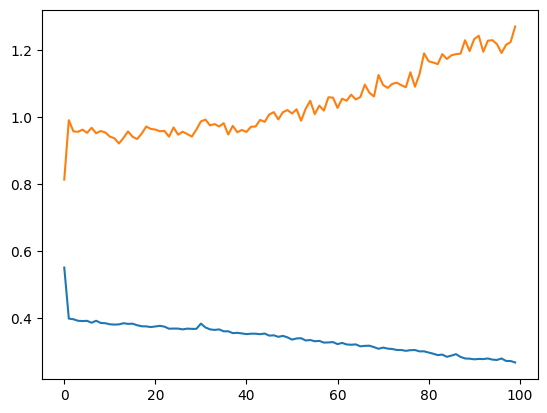

In [9]:
# plot loss
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')